# Imports

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import tensorflow_gnn as tfgnn

2025-05-13 11:02:42.925806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747134162.996673     583 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747134163.015109     583 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747134163.120462     583 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747134163.120482     583 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747134163.120483     583 computation_placer.cc:177] computation placer alr

In [3]:
import pandas as pd
import json
import numpy as np
import itertools
import plotly.express as px
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import DBSCAN
import random

In [4]:
tf.config.set_visible_devices([], 'GPU')
print("Dispositivos visibles:", tf.config.get_visible_devices())

Dispositivos visibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
tf.random.set_seed(14)

# Load data

In [6]:
path = 'almrrc2021/almrrc2021-data-training/model_build_inputs/'

In [7]:
with open(path + 'route_data.json') as f:
  routes = json.load(f)

In [8]:
with open(path + 'actual_sequences.json') as f:
  actual = json.load(f)

In [9]:
with open(path + 'package_data.json') as f:
  package_json = json.load(f)

In [10]:
with open(path + 'travel_times.json') as f:
  times = json.load(f)

In [11]:
rows = []

for route_id, route_info in routes.items():
  general_info = {
    "route_id": route_id,
    "station_code": route_info["station_code"],
    "date": route_info["date_YYYY_MM_DD"],
    "departure_time_utc": route_info["departure_time_utc"],
    "executor_capacity_cm3": route_info["executor_capacity_cm3"],
    "route_score": route_info["route_score"],
  }

  stops = route_info.get("stops", {})
  for stop_id, stop_info in stops.items():
    row = {
      **general_info,
      "stop_id": stop_id,
      "lat": stop_info["lat"],
      "lng": stop_info["lng"],
      "type": stop_info["type"],
      "zone_id": stop_info["zone_id"],
    }
    rows.append(row)

df = pd.DataFrame(rows)

df = df[df["route_score"] != "Low"]

In [12]:
routes_dict = {}

for route, data in df.groupby("route_id"):
  routes_dict[route] = {
      "lat": data["lat"].mean().item(),
      "lng": data["lng"].mean().item()
  }


routes_df = pd.DataFrame(routes_dict).T

coords = routes_df[["lat", "lng"]].to_numpy()

db = DBSCAN(eps=0.01, min_samples=5, metric='haversine').fit(np.radians(coords))
routes_df["cluster"] = db.labels_
routes_df = routes_df.reset_index().rename(columns={"index": "route_id"})

df = df.merge(routes_df[["route_id", "cluster"]], on="route_id", how="left")
df = df[df["cluster"] == 4]

In [13]:
actual_routes_list = []

for route_id in df["route_id"].unique():
    actual_df = pd.DataFrame(actual[route_id])
    actual_df["route_id"] = route_id
    actual_df = actual_df.reset_index().rename(columns={"index": "stop_id", "actual": "order"})
    actual_df["order"] = actual_df["order"].astype(str)
    actual_df["is_start"] = actual_df["order"].apply(lambda x: True if x == "0" else False)
    actual_routes_list.append(actual_df[["route_id", "stop_id", "order", "is_start"]])

actual_routes = pd.concat(actual_routes_list, ignore_index=True)
df = df.merge(actual_routes, on=["route_id", "stop_id"], how="left")

In [14]:
df.loc[pd.isna(df["zone_id"]) & (df["order"] == "0"), "zone_id"] = "Depot"

In [15]:
df["zone_id"] = df["zone_id"].fillna("Unknown")

In [16]:
package_df = pd.DataFrame(package_json)
package_df = package_df.reset_index().rename(columns={"index": "stop_id"})
rows = []
for route in df["route_id"].unique():
    route_packages = package_df[["stop_id", route]].dropna()
    route_packages = route_packages.set_index("stop_id")
    for stop, package in route_packages.iterrows():
        p = package.values[0]
        package_info = list(p.values())
        if len(package_info) > 0:
            rows.append({
                "route_id": route,
                "stop_id": stop,
                "planned_time": package_info[0]["planned_service_time_seconds"],
            })

pdf = pd.DataFrame(rows)

df = df.merge(pdf, on=["route_id", "stop_id"], how="left")

In [17]:
df["order"] = df["order"].apply(lambda x: int(x))

In [18]:
grouped = df.groupby(by="route_id")

# Generate graph

In [19]:
def calculate_time(id_route, stop_list):
    total_time = 0
    for stop in stop_list[:-1]:
        total_time += times[id_route][stop][stop_list[stop_list.index(stop) + 1]]
    return total_time

In [91]:
def create_graph(route, stops_idx, zone_idxs_list):
    src_nodes = []
    dst_nodes = []
    edge_weights = []

    edges = []
    edges_in_path = []
   
    for stop in route.stop_id:
        for stop2 in route.stop_id:
            if stop != stop2:
                src_nodes.append(stops_idx[stop])
                dst_nodes.append(stops_idx[stop2])
                edges.append((stops_idx[stop], stops_idx[stop2]))
                edge_weights.append(times[route_id][stop][stop2])

    predicted_route = route.sort_values(by="order")["stop_id"].tolist()

    for i in range(len(predicted_route) - 1):
        edges_in_path.append((stops_idx[predicted_route[i]], stops_idx[predicted_route[i + 1]]))

    is_in_path = np.zeros(len(edges), dtype=np.int32)
    for i, edge in enumerate(edges):
        if edge in edges_in_path:
            is_in_path[i] = 1

    

    lats = np.array(route.lat.tolist())
    lngs = np.array(route.lng.tolist())

    lat_min, lat_max = lats.min(), lats.max()
    lng_min, lng_max = lngs.min(), lngs.max()

    lats = (lats - lat_min) / (lat_max - lat_min)
    lngs = (lngs - lng_min) / (lng_max - lng_min)

    planned_time = np.array(route.planned_time.tolist())

    time_min, time_max = planned_time.min(), planned_time.max()
    planned_time = (planned_time - time_min) / (time_max - time_min)

    coords = tf.cast(tf.stack([lats, lngs], axis=1), dtype=tf.float16)
    zones = tf.convert_to_tensor(zone_idxs_list, dtype=tf.float16)
    is_start = tf.convert_to_tensor(route.is_start.tolist(), dtype=tf.bool)
    stop_id = tf.convert_to_tensor(list(stops_idx.values()), dtype=tf.float16)

    graph_tensor = tfgnn.GraphTensor.from_pieces(
        node_sets={
            "stops": tfgnn.NodeSet.from_fields(
                sizes=[len(route)],
                features={
                    # "lat": tf.convert_to_tensor(lats, dtype=tf.float16),
                    # "lng": tf.convert_to_tensor(lngs, dtype=tf.float16),
                    "stop_id" : tf.expand_dims(stop_id, axis=1),
                    "coords" : coords,
                    "zone_id": tf.expand_dims(zones, axis=1),
                    "is_start": tf.expand_dims(is_start, axis=1),
                    # "planned_time": tf.convert_to_tensor(planned_time, dtype=tf.float32)
                },
            )
        },
        edge_sets={
            "travel_times": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_weights)],
                adjacency=tfgnn.Adjacency.from_indices(
                    source=("stops", src_nodes),
                    target=("stops", dst_nodes),
                ),
                features={
                    "travel_time": tf.convert_to_tensor(edge_weights, dtype=tf.float16),
                },
            )
        },
    )
                
    return predicted_route, is_in_path, graph_tensor

In [92]:
graph_list = []
target_list_nodes = []
target_list_edges = []
idx_stops_list = []
nx_graphs = []
routes = []

for route_id, route in itertools.islice(grouped, 500):

    routes.append(route)

    stops_idx = {stop: idx for idx, stop in enumerate(route.stop_id)}
    idx_stops = {idx: stop for idx, stop in enumerate(route.stop_id)}
    idx_stops_list.append(idx_stops)

    zone_codes = route["zone_id"].tolist()
    zones_idxs = {zone: i for i, zone in enumerate(set(zone_codes))}
    zone_idxs_list = [zones_idxs[z] for z in zone_codes]

    predicted_route, is_in_path, original_graph = create_graph(route, stops_idx, zone_idxs_list)
    graph_list.append(original_graph)
    
    target_positions = [predicted_route.index(stop) for stop in route.stop_id]
    target_positions = tf.convert_to_tensor(target_positions, tf.int32)

    order = [(int(o), stop_id) for o, stop_id in zip(route.order, route.stop_id)]
    order = sorted(order, key=lambda x: x[0])
    order = [stop_id for _, stop_id in order]
    order = [stops_idx[stop] for stop in order]
    order = tf.convert_to_tensor(order, dtype=tf.int32)

    max_order = tf.math.reduce_max(order)
    min_order = tf.math.reduce_min(order)

    order = (order - min_order) / (max_order - min_order)
    order = tf.cast(order, tf.float16)
    target_list_nodes.append(order)
    target_list_edges.append(is_in_path)

    # route = route.set_index("stop_id")

    # g = nx.DiGraph()
    # g.add_nodes_from(route.index)
    # g.add_edges_from([(stop, stop2, {"weight": times[route_id][stop][stop2]}) for stop in route.index for stop2 in route.index if stop != stop2])
    # nx.set_node_attributes(g, route.lat.to_dict(), "lat")
    # nx.set_node_attributes(g, route.lng.to_dict(), "lng")
    # nx.set_node_attributes(g, route.is_start.to_dict(), "is_start")
    # nx.set_node_attributes(g, route.zone_id.to_dict(), "zone_id")
    # nx_graphs.append(g)

In [93]:
def generator_nodes():
    for graph, target in zip(graph_list, target_list_nodes):
        yield graph, target

def generator_edges():
    for graph, target in zip(graph_list, target_list_edges):
        yield graph, target

In [94]:
node_features = {
    # "lat" : tf.TensorSpec([None], tf.float16),
    # "lng" : tf.TensorSpec([None], tf.float16),
    "stop_id" : tf.TensorSpec([None, 1], tf.float16),
    "coords" : tf.TensorSpec([None, 2], tf.float16),
    "zone_id" : tf.TensorSpec([None, 1], tf.float16),
    "is_start" : tf.TensorSpec([None, 1], tf.bool),
    # "planned_time" : tf.TensorSpec([None], tf.float32),
}

edge_features = {
    "travel_time" : tf.TensorSpec([None], tf.float16),
    # "is_in_path" : tf.TensorSpec([None], tf.float16),
}

adjacency = tfgnn.AdjacencySpec.from_incident_node_sets(
    source_node_set="stops",
    target_node_set="stops",
    index_spec=tf.TensorSpec([None], tf.int32)
)

graph_spec = tfgnn.GraphTensorSpec.from_piece_specs(
    node_sets_spec={
        "stops": tfgnn.NodeSetSpec.from_field_specs(
            features_spec=node_features,
            sizes_spec=tf.TensorSpec([1], tf.int32),
        )
    },
    edge_sets_spec = {
        "travel_times": tfgnn.EdgeSetSpec.from_field_specs(
            features_spec=edge_features,
            sizes_spec=tf.TensorSpec([1], tf.int32),
            adjacency_spec=adjacency
        )
    },
)

In [95]:
for g in graph_list:
    if not graph_spec.is_compatible_with(g):
        print("Graph is not compatible with the spec")
        break

In [96]:
dataset_nodes = tf.data.Dataset.from_generator(
    generator=generator_nodes,
    output_signature=(
        graph_spec,
        tf.TensorSpec(shape=(None,), dtype=tf.float16),
    )
)


dataset_edges = tf.data.Dataset.from_generator(
    generator=generator_edges,
    output_signature=(
        graph_spec,
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
)

# TF-GNN Model

In [26]:
from tensorflow_gnn.models import gat_v2, graph_sage

In [136]:
class GNN(tf.keras.Model):
    def __init__(self, hidden_dim=64, num_layers=3):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.iters = num_layers

        self.map_features = tfgnn.keras.layers.MapFeatures(
            node_sets_fn=self.set_initial_node_state,
            edge_sets_fn=self.set_initial_edge_state
        )

        self.graph_updates = []
        for _ in range(num_layers):
            graph_update = tfgnn.keras.layers.GraphUpdate(
                # edge_sets={
                #     "travel_times": tfgnn.keras.layers.EdgeSetUpdate(
                #         next_state=tfgnn.keras.layers.NextStateFromConcat(
                #             tf.keras.layers.Dense(hidden_dim, activation="elu")
                #         )
                #     )
                # },
                node_sets={
                    # "stops": graph_sage.GCNGraphSAGENodeSetUpdate(
                    #     edge_set_names=["travel_times"],
                    #     receiver_tag=tfgnn.TARGET,
                    #     units=hidden_dim,
                    #     reduce_type="sum"
                    # )
                    "stops": tfgnn.keras.layers.NodeSetUpdate(
                        {"travel_times": tfgnn.keras.layers.SimpleConv(
                            message_fn=tf.keras.layers.Dense(hidden_dim, activation="gelu"),
                            reduce_type="sum"
                        )},
                        next_state=tfgnn.keras.layers.NextStateFromConcat(
                            tf.keras.layers.Dense(hidden_dim, activation="gelu")
                        )
                    )
                }
            )

            # graph_update = gat_v2.GATv2MPNNGraphUpdate(
            #     units=hidden_dim,
            #     message_dim=8 * hidden_dim,
            #     num_heads=8,
            #     receiver_tag=tfgnn.TARGET
            # )
            self.graph_updates.append(graph_update)


    def set_initial_node_state(self, node_set, node_set_name):      
        coords = node_set["coords"]
        zone_id = tf.squeeze(node_set["zone_id"], axis=-1)
        is_start = tf.cast(node_set["is_start"], tf.float16)
        stop_id = tf.squeeze(node_set["stop_id"], axis=-1)


        coords = tf.keras.layers.Dense(self.hidden_dim, activation="gelu", kernel_initializer="he_uniform")(coords)
        zone_id = tf.keras.layers.Embedding(100, self.hidden_dim)(zone_id)
        is_start = tf.keras.layers.Dense(self.hidden_dim, activation="gelu", kernel_initializer="he_uniform")(is_start)
        stop_id = tf.keras.layers.Embedding(300, self.hidden_dim)(stop_id)

        features = tf.concat([coords, zone_id, is_start, stop_id], axis=1) * 5.0

        return features
    

    def set_initial_edge_state(self, edge_set, edge_set_name):
        travel_time = tf.expand_dims(edge_set["travel_time"], -1)
        return tf.keras.layers.Dense(self.hidden_dim, activation="relu")(travel_time)
    

    def call(self, graph):
        graph = self.map_features(graph)
        for update in self.graph_updates:
            graph = update(graph)

            # graph = tfgnn.keras.layers.MapFeatures(
            #     node_sets_fn=lambda node_set, node_set_name: tf.keras.layers.LayerNormalization()(node_set[tfgnn.HIDDEN_STATE]),
            #     edge_sets_fn=None
            # )(graph)
        
        return graph.node_sets["stops"][tfgnn.HIDDEN_STATE]        
        # return graph.edge_sets["travel_times"][tfgnn.HIDDEN_STATE]


In [ ]:
class DenseOutput(tf.keras.Model):
    
    def __init__(self, hidden_size=64):
        super().__init__()

        self.dense = tf.keras.layers.Dense(hidden_size, activation="gelu")
        self.dense2 = tf.keras.layers.Dense(hidden_size // 2, activation="gelu")
        self.output_layer = tf.keras.layers.Dense(1, activation="sigmoid")


    def call(self, node_embeddings):
        x = self.dense(node_embeddings)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = self.dense2(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output = self.output_layer(x)
        output = tf.squeeze(output, axis=-1)
        return output     

In [137]:
gnn = GNN()
do = DenseOutput()
emb = gnn(graph_list[0])
print(emb[0])
print(emb[50])

tf.Tensor(
[    -0.     156794.61   132325.02    22196.723  307855.06       -0.
     -0.     295593.53   104519.05       -0.      95916.445      -0.
     -0.     269014.1        -0.     228641.98       -0.      64501.586
     -0.         -0.      64088.844  138046.75       -0.         -0.
 258520.06   291461.78    35683.203   32392.508      -0.         -0.
     -0.         -0.         -0.     128091.305  153932.62   296214.03
     -0.     139620.92   200995.25       -0.         -0.         -0.
     -0.     159121.95       -0.         -0.         -0.      25272.273
     -0.         -0.         -0.      70822.945      -0.         -0.
  48354.266  180316.19     6633.0024 101017.05    73170.28       -0.
  32230.252  169129.58       -0.     177844.34  ], shape=(64,), dtype=float32)
tf.Tensor(
[    -0.    139028.4   133832.22    9625.781 255649.86      -0.
     -0.    266605.5   107566.28      -0.     85149.18      -0.
     -0.    204873.97      -0.    170127.98      -0.     34561.6
     -0.

In [127]:
class RouteOrder(tf.keras.Model):
    def __init__(self, gnn_hidden_dim=64, gnn_layers=3):
        super().__init__()
        self.gnn = GNN(gnn_hidden_dim, gnn_layers)
        self.dense_output = DenseOutput()

    def call(self, graph):
        node_embeddings = self.gnn(graph)
        # node_embeddings = tf.expand_dims(node_embeddings, 0)
        output = self.dense_output(node_embeddings)
        return output

In [30]:
def get_ordered_pairs_vectorized(y_true):
    y1 = tf.expand_dims(y_true, 0)  # (1, N)
    y2 = tf.expand_dims(y_true, 1)  # (N, 1)

    mask_pos = y1 < y2
    mask_neg = y1 > y2

    pos_pairs = tf.where(mask_pos)
    neg_pairs = tf.where(mask_neg)

    pos_labels = tf.ones(tf.shape(pos_pairs)[0], dtype=tf.float32)
    neg_labels = -tf.ones(tf.shape(neg_pairs)[0], dtype=tf.float32)

    pair_indices = tf.concat([pos_pairs, neg_pairs], axis=0)
    labels = tf.concat([pos_labels, neg_labels], axis=0)

    return pair_indices, labels

def pairwise_ranking_loss(y_pred, pair_indices, labels, margin=1.0):
    i_idx, j_idx = pair_indices[:, 0], pair_indices[:, 1]
    pred_diff = tf.gather(y_pred, i_idx) - tf.gather(y_pred, j_idx)
    # labels: +1 si i debe ir antes que j, -1 si al revés
    losses = tf.maximum(0.0, margin - labels * pred_diff)
    return tf.reduce_mean(losses)

In [138]:
model = RouteOrder(gnn_hidden_dim=64, gnn_layers=3)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
loss_fn = tf.keras.losses.MeanSquaredError()
# loss_fn = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

@tf.function(reduce_retracing=True)
def train_step(graph, order, pair_indices, labels):
    # order = tf.expand_dims(order, axis=0)

    with tf.GradientTape() as tape:
        output = model(graph)
        loss = loss_fn(order, output)
        # loss = pairwise_ranking_loss(output, pair_indices, labels, margin=2.0)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [117]:
# model(graph_list[0])

In [139]:
epochs = 100

for epoch in range(epochs):
    for graph, target in dataset_nodes:
        pair_indices = None
        labels = None
        # pair_indices, labels = get_ordered_pairs_vectorized(target)
        loss = train_step(graph, target, pair_indices, labels)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

Epoch 1, Loss: 0.3354
Epoch 2, Loss: 0.3354
Epoch 3, Loss: 0.3354
Epoch 4, Loss: 0.3354
Epoch 5, Loss: 0.3354
Epoch 6, Loss: 0.3354
Epoch 7, Loss: 0.3354
Epoch 8, Loss: 0.3354
Epoch 9, Loss: 0.3354


KeyboardInterrupt: 

In [34]:
r_idx = 0

In [140]:
pred = model(graph_list[r_idx])
# pred = tf.squeeze(pred, -1)
pred_order = tf.argsort(pred, direction="ASCENDING")
pred_order

<tf.Tensor: shape=(153,), dtype=int32, numpy=
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152], dtype=int32)>

In [108]:
route_id = routes[r_idx].route_id.unique()[0]
route = routes[r_idx]

node_positions = [idx_stops_list[r_idx][idx] for idx in pred_order.numpy()]
actual_order = route.sort_values(by="order")["stop_id"].tolist()
print(f"Predicted order: {node_positions}")
print(f"Actual order: {actual_order}")

print(len(node_positions))
print(len(actual_order))

predicted_time = calculate_time(route_id, node_positions)
actual_time = calculate_time(route_id, actual_order)
print(f"Predicted time: {predicted_time:.2f} seconds")
print(f"Actual time: {actual_time:.2f} seconds")


Predicted order: ['AA', 'UB', 'EI', 'XS', 'RF', 'OY', 'SJ', 'VG', 'IG', 'SG', 'WT', 'PJ', 'HJ', 'NB', 'YN', 'RB', 'GI', 'ST', 'XU', 'MM', 'BR', 'FC', 'LH', 'ZR', 'JH', 'KT', 'LU', 'KE', 'FL', 'JX', 'XG', 'UR', 'SW', 'SV', 'OT', 'MK', 'SE', 'EB', 'NM', 'EU', 'IT', 'OD', 'TL', 'NJ', 'QB', 'RJ', 'YE', 'RO', 'SA', 'CQ', 'SI', 'CS', 'QW', 'ZW', 'HC', 'PM', 'AD', 'FR', 'XH', 'WR', 'KW', 'RE', 'KV', 'NC', 'YA', 'FA', 'GU', 'XI', 'IY', 'XT', 'RM', 'TD', 'WC', 'ME', 'ZU', 'DP', 'YU', 'XE', 'LF', 'SZ', 'WZ', 'FO', 'RV', 'VY', 'EJ', 'PS', 'HW', 'NS', 'WM', 'DJ', 'TJ', 'TY', 'OC', 'EL', 'VR', 'TP', 'DC', 'CG', 'GG', 'AZ', 'KR', 'ZG', 'IM', 'CR', 'IF', 'FJ', 'XV', 'UN', 'ZL', 'SY', 'AQ', 'ZD', 'XL', 'VS', 'KN', 'BW', 'ZQ', 'RX', 'FV', 'CA', 'SK', 'VI', 'BT', 'EF', 'UT', 'NQ', 'NE', 'DF', 'OO', 'VM', 'VB', 'UP', 'XM', 'VA', 'HD', 'BZ', 'EQ', 'PP', 'OZ', 'FY', 'XN', 'QU', 'QN', 'LO', 'MY', 'ZJ', 'ID', 'TE', 'OS', 'JG', 'CE', 'PW', 'YI']
Actual order: ['UB', 'NE', 'KN', 'PS', 'AD', 'BZ', 'XV', 'XN', '

In [97]:
zones = []
true_zones = []
all_zones = []

for stop in node_positions:
    zone = route[route["stop_id"] == stop]["zone_id"].values[0]
    all_zones.append(zone)
    if zone not in zones:
        zones.append(zone)

for stop in actual_order:
    zone = route[route["stop_id"] == stop]["zone_id"].values[0]
    if zone not in true_zones:
        true_zones.append(zone)
    
print(zones)
print(true_zones)

['A-8.2J', 'A-7.2J', 'A-8.3B', 'Depot', 'A-8.3G', 'A-8.2B', 'A-8.1J', 'A-8.2C', 'A-8.2D', 'A-8.2E', 'A-8.1G', 'A-8.3H', 'A-8.1E', 'A-8.3J', 'A-8.1H', 'A-7.3J', 'A-8.2G', 'A-8.2H', 'A-8.3C', 'A-8.3D', 'A-8.1C', 'A-8.3E', 'A-8.1D']
['Depot', 'A-8.3G', 'A-7.2J', 'A-7.3J', 'A-8.3J', 'A-8.2J', 'A-8.1J', 'A-8.1H', 'A-8.2H', 'A-8.3H', 'A-8.2G', 'A-8.1G', 'A-8.1E', 'A-8.2E', 'A-8.3E', 'A-8.3D', 'A-8.2D', 'A-8.1D', 'A-8.3C', 'A-8.1C', 'A-8.2C', 'A-8.3B', 'A-8.2B']


In [423]:
predicted_order = route["stop_id"].apply(lambda x: str(node_positions.index(x)))
str_order = route["order"].apply(lambda x: str(x))

df_plot = df[df["zone_id"] == "A-8.2D"]
str_order_all = df["order"].apply(lambda x: str(x))

In [428]:
fig = px.scatter_map(
    df_plot,
    lat="lat",
    lon="lng",
    color="zone_id",
    text=str_order_all,
    # hover_name=predicted_order,
    zoom=15,
    height=1000,
)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker=dict(size=20))
fig.update_traces(textposition='middle center', textfont_size=8)

fig.show(config={"scrollZoom": True})

ShapeError: Expected object of length 30705, got length: 35

Mean difference: 11188.88 seconds
Min difference: 4494.70 seconds
Max difference: 25934.00 seconds
Position with max difference: 102


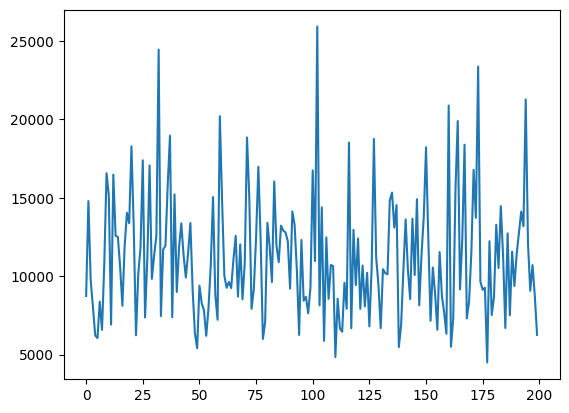

In [386]:
difs = np.zeros(200)

for i in range(200):
    pred = model(graph_list[i])
    pred = tf.squeeze(pred, -1)
    pred_order = tf.argsort(pred, direction="DESCENDING")

    route_id = routes[i].route_id.unique()[0]
    route = routes[i]

    node_positions = [idx_stops_list[i][idx] for idx in pred_order.numpy()]
    actual_order = route.sort_values(by="order")["stop_id"].tolist()

    predicted_time = calculate_time(route_id, node_positions)
    actual_time = calculate_time(route_id, actual_order)

    dif = predicted_time - actual_time
    difs[i] = dif
    
print(f"Mean difference: {np.mean(difs):.2f} seconds")
print(f"Min difference: {np.min(difs):.2f} seconds")
print(f"Max difference: {np.max(difs):.2f} seconds")

print("Position with max difference:", np.argmax(difs))

plt.plot(difs)

With Dense:

Mean difference: 11146.79 seconds

Min difference: 4845.70 seconds

Max difference: 26084.90 seconds

Position with max difference: 102

In [207]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS,
]

tflit_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflit_model)

INFO:tensorflow:Assets written to: /tmp/tmp3qkuo5of/assets


/home/coder/.local/lib/python3.12/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/coder/.local/lib/python3.12/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/coder/.local/lib/python3.12/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a Str

# Tests